### データのダウンロード

In [1]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 12.5 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=7e57bb9a843f7a1fe805276de890f0ad50cc438ef58afb49a3276732462be99b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
requests 2.23.0 requires urllib3!

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [2]:
! signate list
! signate files --competition-id=133
! signate download --competition-id=133

  competitionId  title                                                                             closing     prize        submitters
---------------  --------------------------------------------------------------------------------  ----------  ---------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                              5893
             24  【練習問題】お弁当の需要予測                                                      -                              7340
             27  【練習問題】Jリーグの観客動員数予測                                               -                              1763
            100  【練習問題】手書き文字認識                                                        -           Knowledge           226
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge          1686
            103  【練習問題】音楽ラベリング                                                        -           Knowledge            98
            

In [3]:
!unzip -q train_images.zip

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/cifar10/notebooks

/content/drive/MyDrive/Colab Notebooks/cifar10/notebooks


In [6]:
!pip install -q timm

     |████████████████████████████████| 509 kB 7.1 MB/s 
     |████████████████████████████████| 127 kB 94.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
signate 0.9.9 requires urllib3>=1.26.7, but you have urllib3 1.25.11 which is incompatible.


In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch import nn, optim

import timm

from src import (
    colab_save_model, set_device, seed_torch,
    DataTransform, CifarDataset, make_dataloader,
    EarlyStopping, make_scheduler
)


In [8]:
device = set_device()

device：cuda


In [9]:
seed_torch()

set random seed


In [10]:
smp = colab_save_model(True, attach_path='/content/drive/MyDrive/Colab Notebooks/cifar10')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Save model path: /content/drive/MyDrive/Colab Notebooks/cifar10/model/


In [11]:
print(smp)

/content/drive/MyDrive/Colab Notebooks/cifar10/model/


### データの読み込み

In [12]:
# read label data
train_master = pd.read_csv('/content/train_master.tsv', sep='\t')
print(train_master.head())
print('データ数: ', train_master.shape[0])

     file_name  label_id
0  train_0.jpg         1
1  train_1.jpg         5
2  train_2.jpg         1
3  train_3.jpg         6
4  train_4.jpg         3
データ数:  5000


In [13]:
# image name list
image_name_list = train_master['file_name'].values
print('データ数: ', len(image_name_list))

# label list
label_list = train_master['label_id'].values

データ数:  5000


In [14]:
# split train & val
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=0.25, stratify=label_list, random_state=42)

In [15]:
# dataset
train_dataset = CifarDataset(x_train, y_train, '/content/train_images',transform=DataTransform(), phase='train')
val_dataset = CifarDataset(x_val, y_val, '/content/train_images', transform=DataTransform(), phase='val')

In [16]:
dataloader = make_dataloader(train_dataset, val_dataset, 64, 64)

### モデルの定義

In [17]:
model = timm.create_model('convnext_base', pretrained=True, num_classes=10)
model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), e

In [18]:
# loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)

In [19]:
ers = EarlyStopping(patience=20, verbose=1)
scheduler = make_scheduler(optimizer, 'max', 0.5, 5, 1e-5, True)

In [20]:
import torch

from collections import defaultdict

# training model
def train_model(model, epochs, loss_fn, optimizer, save_model_path, model_name):

    # 学習履歴を保存するdictオブジェクト
    history = defaultdict(list)
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            accuracy = accuracy.to('cpu').detach().numpy().copy()
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'{save_model_path}{model_name}_loss_{best_loss:.4f}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
        
        # スケジューラー、テストデータの精度を監視する
        scheduler.step(epoch_loss)

        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break

    # 正解率の推移をプロット
    plt.plot(history['train_accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # ロスの推移をプロット
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Epoch: 1 / 5
--------------------------
train Loss: 0.7895 Accuracy: 0.7536
val Loss: 0.3159 Accuracy: 0.9008
Epoch: 2 / 5
--------------------------
train Loss: 0.4375 Accuracy: 0.8563
val Loss: 0.3782 Accuracy: 0.8760
Epoch: 3 / 5
--------------------------
train Loss: 0.3632 Accuracy: 0.8803
val Loss: 0.3069 Accuracy: 0.9032
Epoch: 4 / 5
--------------------------
train Loss: 0.3013 Accuracy: 0.8981
val Loss: 0.3079 Accuracy: 0.9016
Epoch: 5 / 5
--------------------------
train Loss: 0.2904 Accuracy: 0.9051
val Loss: 0.3714 Accuracy: 0.8800


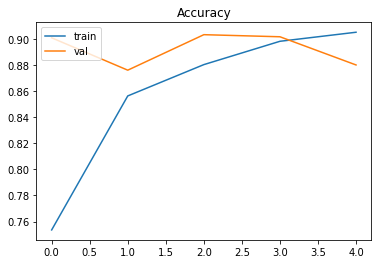

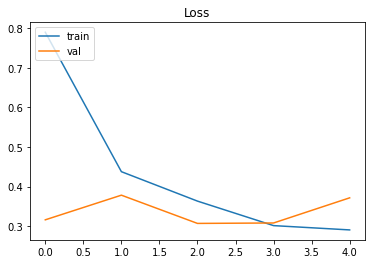

In [21]:
train_model(model, 5, criterion, optimizer, smp, 'convnext_base')